In [1]:
%load_ext autoreload
%autoreload 2

# Experiments on Toy Data

In [2]:
from aggregation import experiment
import numpy as np

mses, cates = experiment(4, n=500, random_state=3)

Fitting meta learners on dtrain
Fitting ensemble train on dval
Fitting ensemble val on dval
Fitting ensemble cfit on dval
Fitting ensemble 3way on dval
Fitting meta learners on dtrain union dval
Evaluating all models on dtest


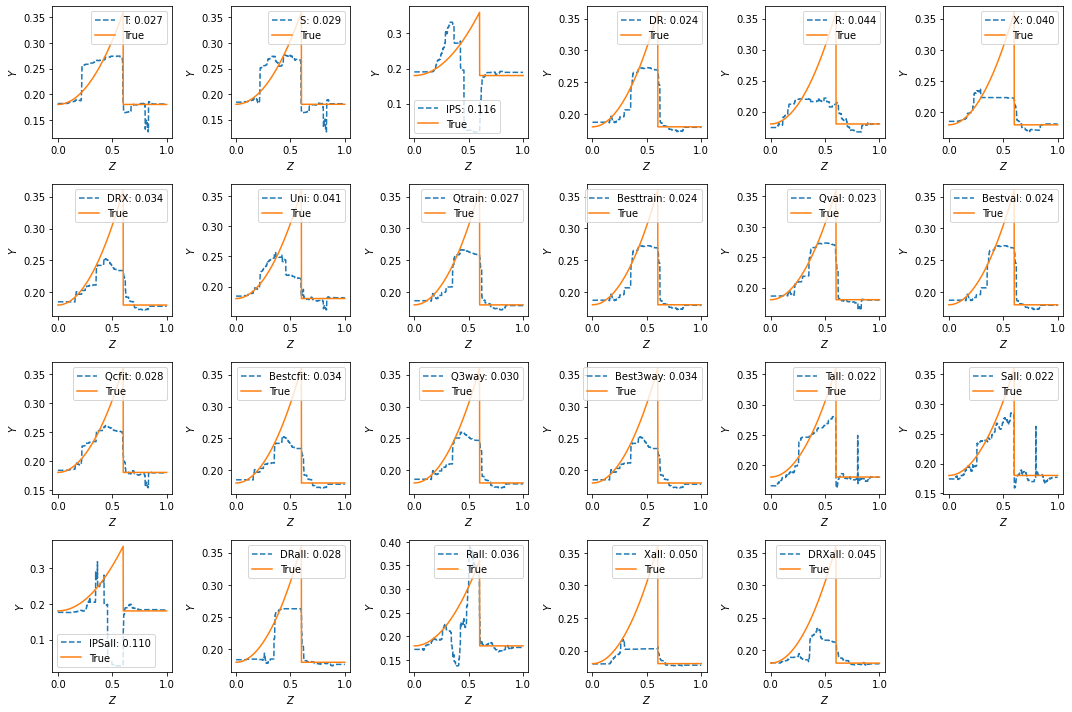

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))
for it, (name, mse) in enumerate(mses.items()):
    plt.subplot(4, 6, it + 1)
    plt.plot(cates['Ztest'], cates[name], '--', label=f'{name}: {np.sqrt(mse):.3f}')
    plt.plot(cates['Ztest'], cates['True'], '-', label=f'True')
    plt.xlabel('$Z$')
    plt.ylabel('$Y$')
    plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
from aggregation import experiment
import numpy as np
import joblib
from joblib import Parallel, delayed 

all_results = {}
for n in [500, 1000, 10000]:
    for dgp in np.arange(1, 7):
        all_results[(n, dgp)] = Parallel(n_jobs=-1, verbose=3)(delayed(experiment)(dgp, n=n,
                                                                              random_state=it)
                                                          for it in range(100))
        joblib.dump(all_results, 'all_results.jbl')

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import joblib
plt.figure(figsize=(15, 10))
it = 1
attr = '95'
ylabel = 'Median RMSE Regret'
all_results = joblib.load('all_results.jbl')
ngrid = [250, 500, 750, 1000, 2000]
for dgp in np.arange(1, 7):
    rmses_agg = {}
    for n in ngrid:
        results = all_results[(n, dgp)]
        
        for r in results:
            r[1]['Uni'] = np.array([r[1][name] for name in ['T', 'S', 'IPS', 'DR', 'R', 'X', 'DRX']]).mean(axis=0)
            r[0]['Uni'] = np.mean((r[1]['Uni'] - r[1]['True'])**2)

        mses, _ = results[0]
        names = list(mses.keys())
        rmses_agg[n] = {}
        oracle = np.min(np.array([np.sqrt(np.array([r[0][name] for r in results])) for name in names
                                  if ((not name.startswith('Q')) and (not name.startswith('Best'))
                                      and (not name.startswith('Uni')))]),
                        axis=0)
        for name in names:
            rmses = np.sqrt(np.array([r[0][name] for r in results])) #- oracle
            rmses_agg[n][name] = {'mean': np.mean(rmses), 'std': np.std(rmses),
                                   'stderr': np.std(rmses) / np.sqrt(len(results)),
                                   'median': np.median(rmses), '5': np.percentile(rmses, 5),
                                   '95': np.percentile(rmses, 95)}

    
    plt.subplot(2, 3, it)
    plt.plot(ngrid, [rmses_agg[n]['Qval'][attr] for n in ngrid], linewidth=5, label='Qval')
    for name in ['X', 'Uni', 'DRX', 'R', 'T', 'DR']:
        plt.plot(ngrid, [rmses_agg[n][name][attr] for n in ngrid], label=name)
    plt.title(f'DGP: {dgp}')
    plt.legend()
    plt.xlabel('n')
    plt.ylabel(ylabel)
    it += 1
plt.tight_layout()
plt.savefig('median_rmse_regret_qtrain.png', dpi=600)
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import joblib
plt.figure(figsize=(15, 10))
it = 1
attr = 'median'
ylabel = 'Median RMSE Regret'
# all_results = joblib.load('all_results.jbl')
ngrid = [250, 500, 1000, 2000]
for dgp in np.arange(1, 7):
    rmses_agg = {}
    for n in ngrid:
        results = all_results[(n, dgp)]
        
        for r in results:
            r[1]['Uni'] = np.array([r[1][name] for name in ['T', 'S', 'IPS', 'DR', 'R', 'X', 'DRX']]).mean(axis=0)
            r[0]['Uni'] = np.mean((r[1]['Uni'] - r[1]['True'])**2)

        mses, _ = results[0]
        names = list(mses.keys())
        rmses_agg[n] = {}
        oracle = np.min(np.array([np.sqrt(np.array([r[0][name] for r in results])) for name in names
                                  if ((not name.startswith('Q')) and (not name.startswith('Best'))
                                      and (not name.startswith('Uni')))]),
                        axis=0)
        for name in names:
            rmses = np.sqrt(np.array([r[0][name] for r in results])) #- oracle
            rmses_agg[n][name] = {'mean': np.mean(rmses), 'std': np.std(rmses),
                                   'stderr': np.std(rmses) / np.sqrt(len(results)),
                                   'median': np.median(rmses), '5': np.percentile(rmses, 5),
                                   '95': np.percentile(rmses, 95)}

    
    plt.subplot(2, 3, it)
    plt.plot(ngrid, [rmses_agg[n]['Qval'][attr] for n in ngrid], linewidth=5, label='Qval')
    for name in ['X', 'Uni', 'DRX', 'R', 'T', 'DR']:
        plt.plot(ngrid, [rmses_agg[n][name][attr] for n in ngrid], label=name)
    plt.title(f'DGP: {dgp}')
    plt.legend()
    plt.xlabel('n')
    plt.ylabel(ylabel)
    it += 1
plt.tight_layout()
plt.savefig('median_rmse_regret_qtrain.png', dpi=600)
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import joblib

#all_results = joblib.load('all_results.jbl')
rmses_agg = {}
for dgp in np.arange(1, 3):
    rmses_agg[f'DGP {dgp}'] = {}
    for n in [250, 500, 750, 1000, 2000, 5000, 10000]:
        results = all_results[(n, dgp)]
        
        for r in results:
            r[1]['Uni'] = np.array([r[1][name] for name in ['T', 'S', 'IPS', 'DR', 'R', 'X', 'DRX']]).mean(axis=0)
            r[0]['Uni'] = np.mean((r[1]['Uni'] - r[1]['True'])**2)

        mses, _ = results[0]
        names = list(mses.keys())
        rmses_agg[f'DGP {dgp}'][n] = {}
        oracle = np.min(np.array([np.sqrt(np.array([r[0][name] for r in results])) for name in names
                                  if ((not name.startswith('Q')) and (not name.startswith('Best'))
                                      and (not name.startswith('Uni')))]),
                        axis=0)
        for name in names:
            rmses = np.sqrt(np.array([r[0][name] for r in results])) - oracle
            rmses_agg[f'DGP {dgp}'][n][name] = f'{np.median(rmses):.2f} ({np.percentile(rmses, 95):.2f})'

    rmses_agg[f'DGP {dgp}'] = pd.DataFrame(rmses_agg[f'DGP {dgp}'])

table = pd.concat(rmses_agg, axis=1)

In [ ]:
table

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import joblib

all_results = joblib.load('all_results.jbl')
for n in [250, 500, 1000, 10000]:
    for dgp in np.arange(1, 3):
        results = all_results[(n, dgp)]
        mses, _ = results[0]
        names = list(mses.keys())
        rmses_agg = {}
        rmses_all = {}
        for name in names:
            rmses = np.sqrt(np.array([r[0][name] for r in results]))
            # clip top 1% failure modes
            q1 = np.percentile(rmses, 99)
            rmses = rmses[(rmses<q1)]
            rmses_all[name] = rmses
            rmses_agg[name] = {'mean': np.mean(rmses), 'std': np.std(rmses),
                               'stderr': np.std(rmses) / np.sqrt(len(results)),
                               'median': np.median(rmses)}

        agg_means = pd.DataFrame(rmses_agg).T['mean'].values
        min_rmse = np.min(agg_means)
        min_ind = np.argmin(agg_means)
        min_name = names[min_ind]
        min_rmse_std = rmses_agg[min_name]['stderr']
        print(min_rmse, min_name, min_rmse_std)
        
        oracle = np.min(np.array([np.sqrt(np.array([r[0][name] for r in results])) for name in names
                                  if ((not name.startswith('Q')) and (not name.startswith('Best'))
                                      and (not name.startswith('Uni')))]),
                        axis=0)
        rmses_all['oracle'] = oracle
        rmses_agg['oracle'] = {'mean': np.mean(oracle), 'std': np.std(oracle),
                               'stderr': np.std(oracle) / np.sqrt(len(results)),
                               'median': np.median(oracle)}

        plt.show()
        it = 0
        for name, agg in rmses_agg.items():
            mean = agg['mean']
            if mean >= min_rmse + 20*min_rmse_std:
                continue
            plt.violinplot(rmses_all[name], positions=[it], showmeans=False, showmedians=True,
                           showextrema=True, quantiles=[.1, .9])
            plt.scatter(name, mean)
            it += 1
        plt.title(f'DGP: {dgp} (n={n})')
        plt.xlabel('Method')
        plt.ylabel('RMSE')
        plt.xlim([-1, it])
        plt.show()
        display(pd.DataFrame(rmses_agg).T)

# Experiments on Semi-Synthetic Data

In [ ]:
data = 'welfare' # which dataset, one of {'401k', 'criteo', 'welfare', 'poverty', 'star'}

## For semi-synthetic data generation
semi_synth = True # Whether true outcome y should be replaced by a fake outcome from a known CEF
simple_synth = True # Whether the true CEF of the fake y should be simple or fitted from data
max_depth = 2 # max depth of random forest during for semi-synthetic model fitting
scale = .2 # magnitude of noise in semi-synthetic data
def simple_true_cef(D, X): # simple CEF of the outcome for semi-synthetic data
    return .5 * np.array(X)[:, 1] * D + np.array(X)[:, 1]

In [ ]:
mses, cates = experiment(data,
                         semi_synth=semi_synth,
                         simple_synth=simple_synth,
                         max_depth=max_depth,
                         scale=scale,
                         true_f=simple_true_cef,
                         random_state=1)

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for it, (name, mse) in enumerate(mses.items()):
    plt.subplot(4, 4, it + 1)
    plt.scatter(cates['Ztest'][:, 1], cates[name], label=f'{name}: {np.sqrt(mse):.4f}')
    plt.scatter(cates['Ztest'][:, 1], cates['True'],  label=f'True')
    plt.xlabel('$Z$')
    plt.ylabel('$Y$')
    plt.legend()
plt.show()

In [ ]:
results = Parallel(n_jobs=-1, verbose=3)(delayed(experiment)(data,
                                                             semi_synth=semi_synth,
                                                             simple_synth=simple_synth,
                                                             max_depth=max_depth,
                                                             scale=scale,
                                                             true_f=simple_true_cef,
                                                             random_state=it)
                                                  for it in range(100))

In [ ]:
mses, _ = results[0]
names = list(mses.keys())
rmses_agg = {}
rmses_all = {}
for name in names:
    rmses = np.sqrt(np.array([r[0][name] for r in results]))
    # clip top 1% failure modes
    q1 = np.percentile(rmses, 99)
    rmses = rmses[(rmses<q1)]
    rmses_all[name] = rmses
    rmses_agg[name] = {'mean': np.mean(rmses), 'std': np.std(rmses),
                       'stderr': np.std(rmses) / np.sqrt(len(results)),
                       'median': np.median(rmses)}

agg_means = pd.DataFrame(rmses_agg).T['mean'].values
min_rmse = np.min(agg_means)
min_ind = np.argmin(agg_means)
min_name = names[min_ind]
min_rmse_std = rmses_agg[min_name]['stderr']
print(min_rmse, min_name, min_rmse_std)

oracle = np.min(np.array([np.sqrt(np.array([r[0][name] for r in results])) for name in names
                          if ((not name.startswith('Q')) and (not name.startswith('Best'))
                              and (not name.startswith('Uni')))]),
                axis=0)
rmses_all['oracle'] = oracle
rmses_agg['oracle'] = {'mean': np.mean(oracle), 'std': np.std(oracle),
                       'stderr': np.std(oracle) / np.sqrt(len(results)),
                       'median': np.median(oracle)}

plt.show()
it = 0
for name, agg in rmses_agg.items():
    mean = agg['mean']
    if mean >= min_rmse + 20*min_rmse_std:
        continue
    plt.violinplot(rmses_all[name], positions=[it], showmeans=False, showmedians=True,
                   showextrema=True, quantiles=[.1, .9])
    plt.scatter(name, mean)
    it += 1
plt.title(f'DGP: {dgp} (n={n})')
plt.xlabel('Method')
plt.ylabel('RMSE')
plt.xlim([-1, it])
plt.show()
display(pd.DataFrame(rmses_agg).T)